In [1]:
import cv2
import tensorflow as tf
import os
import numpy as np
import network as net
from Training_rnn_network_3d import openpose
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter
import math
from collections import Counter, defaultdict
import itertools
import matplotlib as mpl
import time
import ast
from scipy.ndimage.filters import gaussian_filter
import matplotlib
#from keras.models import Model

C:\Users\JAEKYU\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


cell end


In [2]:
def make_test_batch(img_path, batch_size):
    num_of_data = len(img_path)
    index = np.arange(0, num_of_data)
    np.random.shuffle(index)
    index = index[:batch_size]
    
    shuffled_img_data = [img_path[i] for i in index]
    
    return np.asarray(shuffled_img_data)

def path_to_image(img_path, batch_size):
    #buffer 선언
    image_data = np.zeros((batch_size, 356, 356, 3), np.uint8)
    
    index = 0
    for img in (img_path):
        #buffer = cv2.imread(img)
        #buffer = cv2.resize(buffer, (526, 526))
        #image_data[index] = buffer
        #index = index + 1
        #buffer = cv2.resize(buffer, (526, 526))

        image_data[index] = cv2.imread(img)
        index = index + 1

    return image_data

def load_test_data(save_path):
    img_path = save_path#"./MPII_Dataset/resized_test_image/"
    file_path = []
    file_list = os.listdir(img_path)
    for i in (file_list):
        file_path.append(img_path + i)
    return file_path

def padRightDownCorner(img, stride, padValue):
    h = img.shape[0]
    w = img.shape[1]

    pad = 4 * [None]
    pad[0] = 0 # up
    pad[1] = 0 # left
    pad[2] = 0 if (h%stride==0) else stride - (h % stride) # down
    pad[3] = 0 if (w%stride==0) else stride - (w % stride) # right

    img_padded = img
    pad_up = np.tile(img_padded[0:1,:,:]*0 + padValue, (pad[0], 1, 1))
    img_padded = np.concatenate((pad_up, img_padded), axis=0)
    pad_left = np.tile(img_padded[:,0:1,:]*0 + padValue, (1, pad[1], 1))
    img_padded = np.concatenate((pad_left, img_padded), axis=1)
    pad_down = np.tile(img_padded[-2:-1,:,:]*0 + padValue, (pad[2], 1, 1))
    img_padded = np.concatenate((img_padded, pad_down), axis=0)
    pad_right = np.tile(img_padded[:,-2:-1,:]*0 + padValue, (1, pad[3], 1))
    img_padded = np.concatenate((img_padded, pad_right), axis=1)

    return img_padded, pad

In [3]:
#nms_joint = []
def demo_view(oriImg, input_heatmap, input_paf):
    #input_heatmap = np.squeeze(input_heatmap)
    heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 17))
    paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 34))

    
    heatmap_avg = heatmap_avg + input_heatmap
    paf_avg = paf_avg + input_paf
    all_peaks = []
    peak_counter = 0

    for part in range(17-1):
        map_ori = heatmap_avg[:,:,part]
        map = gaussian_filter(map_ori, sigma=3)

        map_left = np.zeros(map.shape)
        #print(np.shape(map_left))
        map_left[1:,:] = map[:-1,:]
        map_right = np.zeros(map.shape)
        map_right[:-1,:] = map[1:,:]
        map_up = np.zeros(map.shape)
        map_up[:,1:] = map[:,:-1]
        map_down = np.zeros(map.shape)
        map_down[:,:-1] = map[:,1:]

        peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up,\
                                              map>=map_down, map > 0.1))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
        peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
        id = range(peak_counter, peak_counter + len(peaks))
        peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)


    connection_all = []
    special_k = []
    mid_num = 10###########################################################################################
    #paf_avg = resized_vectormap
    for k in range(len(mapIdx)):
        score_mid = paf_avg[:,:,[x-17 for x in mapIdx[k]]]
        #print("score_mid : ",np.shape(score_mid))
        candA = all_peaks[limbSeq[k][0]]#all_peaks[limbSeq[k][0]-1]#157
        candB = all_peaks[limbSeq[k][1]]#all_peaks[limbSeq[k][1]-1]#246
        #candA : [(182, 68, 0.8127860426902771, 9)]
        #candB :[(173, 92, 0.8721999526023865, 8)]
        #print("candA, candB : ",candA, candB)
        nA = len(candA)
        nB = len(candB)
        #print("nA, nB : ", nA, nB)
        indexA, indexB = limbSeq[k]
        #print("indexA, indexB : ", indexA, indexB)
        if(nA != 0 and nB != 0):
            connection_candidate = []
            for i in range(nA):
                for j in range(nB):
                    vec = np.subtract(candB[j][:2], candA[i][:2])
                    norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                    # failure case when 2 body parts overlaps
                    if norm == 0:
                        continue
                    vec = np.divide(vec, norm)

                    startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                   np.linspace(candA[i][1], candB[j][1], num=mid_num)))

                    vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                      for I in range(len(startend))])

                    vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                      for I in range(len(startend))])

                    score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                    score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                    #print("score_midpts : ", score_midpts)
                    criterion1 = len(np.nonzero(score_midpts > 0.0001)[0]) > 0.00005 * len(score_midpts)
                    #print("score_with_dist_prior : ", score_with_dist_prior)
                    criterion2 = score_with_dist_prior > 0.1
                    #print("criterion1, criterion2 : ", criterion1, criterion2)
                    if criterion1 and criterion2:
                        #print("1")
                        connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
            #print("connection_candidate : ", connection_candidate)
            connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
            connection = np.zeros((0,5))
            #print("connection_candidate : ", connection_candidate)
            for c in range(len(connection_candidate)):
                i,j,s = connection_candidate[c][0:3]
                if(i not in connection[:,3] and j not in connection[:,4]):
                    connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                    if(len(connection) >= min(nA, nB)):
                        break
            #print("connection : ", connection)
            connection_all.append(connection)
        else:
            special_k.append(k)
            connection_all.append([])
    subset = -1 * np.ones((0, 20))######################################################
    #print("subset1 : ", subset)
    candidate = np.array([item for sublist in all_peaks for item in sublist])
    #print("candidate : ", candidate)
    #print("all_peaks : ", all_peaks)
    for k in range(len(mapIdx)):
        #print("--------------------------------------------")
        #print("k : ", k)
        #print("special_k : ", special_k)
        if k not in special_k:
            #print("k is not in special_k : ",k)
            partAs = connection_all[k][:,0]
            partBs = connection_all[k][:,1]
            indexA, indexB = np.array(limbSeq[k]) - 1

            #print("connection_all : ",connection_all)
            #print("connection_all[k] : ",connection_all[k])
            for i in range(len(connection_all[k])): #= 1:size(temp,1)
                #print("hello")
                found = 0
                subset_idx = [-1, -1]
                #print("subset's length :", len(subset))
                for j in range(len(subset)): #1:size(subset,1):
                    #print("subset3 : ", subset)
                    if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                        subset_idx[found] = j
                        found += 1
                #print("found : ",found)
                if found == 1:
                    j = subset_idx[0]
                    if(subset[j][indexB] != partBs[i]):
                        subset[j][indexB] = partBs[i]
                        subset[j][-1] += 1
                        subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                elif found == 2: # if found 2 and disjoint, merge them
                    j1, j2 = subset_idx
                    #print ("found = 2")
                    membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                    if len(np.nonzero(membership == 2)[0]) == 0: #merge
                        subset[j1][:-2] += (subset[j2][:-2] + 1)
                        subset[j1][-2:] += subset[j2][-2:]
                        subset[j1][-2] += connection_all[k][i][2]
                        subset = np.delete(subset, j2, 0)
                    else: # as like found == 1
                        subset[j1][indexB] = partBs[i]
                        subset[j1][-1] += 1
                        subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(20)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    row[-1] = 2
                    row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                    subset = np.vstack([subset, row])
    #print("end~",subset)
    # delete some rows of subset which has few parts occur
    deleteIdx = [];
    #print(subset)
    for i in range(len(subset)):
        #print(subset[i][-1])
        if subset[i][-1] < 1 or subset[i][-2]/subset[i][-1] < 0.3:
            deleteIdx.append(i)
            #print(i)
    subset = np.delete(subset, deleteIdx, axis=0)
    #print(subset)
    # visualize

    cmap = matplotlib.cm.get_cmap('hsv')

    canvas = oriImg#cv2.imread(oriImg) # B,G,R order
    #canvas = canvas[:, :, (2,1,0)]
    #print(all_peaks)########################################################################################
    #nms_joint.append(all_peaks)
    #all_peaks_file = ",".join(str(x) for x in all_peaks)
    #f.write(all_peaks_file)
    #f.write("\n")
    
    for i in range(16):
        rgba = np.array(cmap(1 - i/16. - 1./32))
        rgba[0:3] *= 255

        for j in range(len(all_peaks[i])):
            #print((all_peaks[i][j]))
            #x = all_peaks[i][j][3]
            #y = all_peaks[i][j][1]
            cv2.circle(canvas, all_peaks[i][j][0:2], 2, colors[i], thickness=-1)
            #cv2.circle(canvas, (x, y), 1, colors[i], thickness=-1)

    to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)


    # visualize 2# visual 
    stickwidth = 1

    for i in range(15):
        for n in range(len(subset)):
            index = subset[n][np.array(limbSeq[i])-1]
            #print("index : ", index)
            if -1 in index:
                continue
            #print("hello")
            cur_canvas = canvas.copy()
            Y = candidate[index.astype(int), 0]
            X = candidate[index.astype(int), 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
    return canvas[:,:,[2,1,0]]

In [4]:
limbSeq = [(9, 8), (8, 13), (8, 12), (8, 7), (12, 11), (11, 10), (13, 14), (14, 15), \
           (7, 6), (6, 3),  (3, 4),  (4, 5), (6, 2),   (2, 1),   (1, 0)]#16개 조인트, 15개 limb

mapIdx = [(16, 17), (18, 19), (20, 21), (22, 23), (28, 29), (30, 31), (24, 25), (26, 27), (32, 33), \
          (34, 35), (38, 39), (40, 41), (36, 37), (42, 43), (44, 45)]#x, y vectormap Pairs 24,25

colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

In [5]:
"""import cv2
import numpy as np

cap = cv2.VideoCapture('./video/1.avi')
_60_frame_data = []
i = 0
while(i != 60):
    ret, img_color = cap.read()
    img_color = cv2.resize(img_color, (112, 112))
    if ret == False:
        continue
    #output = output[...,::-1]
    cv2.imshow('bgr', img_color)
    #27 -> esc
    
    _60_frame_data.append(img_color)
    
    if cv2.waitKey(1) & 0xFF == 27:
        break
    i = i + 1
print("w")
cap.release()
cv2.destroyAllWindows()
np.shape(_60_frame_data)"""

'import cv2\nimport numpy as np\n\ncap = cv2.VideoCapture(\'./video/1.avi\')\n_60_frame_data = []\ni = 0\nwhile(i != 60):\n    ret, img_color = cap.read()\n    img_color = cv2.resize(img_color, (112, 112))\n    if ret == False:\n        continue\n    #output = output[...,::-1]\n    cv2.imshow(\'bgr\', img_color)\n    #27 -> esc\n    \n    _60_frame_data.append(img_color)\n    \n    if cv2.waitKey(1) & 0xFF == 27:\n        break\n    i = i + 1\nprint("w")\ncap.release()\ncv2.destroyAllWindows()\nnp.shape(_60_frame_data)'

In [6]:
test_video_path = './video_with_abstacle/for_test/youtube/60frame_video/110.avi'
output_video_path = './video_with_abstacle/for_test/youtube/60frame_video/_110.avi'
_60_frame_data = []
with tf.Session() as sess:
    obj = openpose(batch_size=1, sess = sess)
    #cap = cv2.VideoCapture(test_video_path)
    #
    #
    #
    #length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    #for i in range(length):
    #    
    #    ret, img_color = cap.read()
    #    img_color = cv2.resize(img_color, (112, 112))
    #    
    #    #output = output[...,::-1]
    #    cv2.imshow('bgr', img_color)
    #    #27 -> esc
    #    
    #    _60_frame_data.append(img_color)
    #    if ret == False:
    #        continue
    #    if cv2.waitKey(1) & 0xFF == 27:
    #        break
    ##print("w")
    #cap.release()
    #cv2.destroyAllWindows()
    vectormap, heatmap, vgg, _60_frame_data = obj.test()
#print(np.shape(_60_frame_data), np.shape(heatmap),np.shape(paf))

test data load start
test data load finish
vgg_19_3d_output :  (?, 60, 14, 14, 25)
RNN output's shape :  (1, 60, 4900)
RNN reshaped output's shape :  (1, 60, 14, 14, 25)
block_3d_stage_1_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_1_branch2 :  (1, 60, 14, 14, 17)
block_3d_stage_2_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_2_branch2 :  (1, 60, 14, 14, 17)
block_3d_stage_3_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_3_branch2 :  (1, 60, 14, 14, 17)
block_3d_stage_4_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_4_branch2 :  (1, 60, 14, 14, 17)
block_3d_stage_5_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_5_branch2 :  (1, 60, 14, 14, 17)
block_3d_stage_6_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_6_branch2 :  (1, 60, 14, 14, 17)
open pose init complete
test video :  ['./video_with_abstacle/TrainingSet_2/3/100.avi']
graph init start
graph init finish
INFO:tensorflow:Restoring parameters from C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight_rnn/Weight.ckpt
-------------

_transpose_heatmap's shape :  (60, 14, 14, 17)
_transpose_vectormap's shape :  (60, 14, 14, 34)
__transpose_heatmap's shape :  (60, 17, 14, 14)
__transpose_vectormap's shape :  (60, 34, 14, 14)
(60, 17, 14, 14)


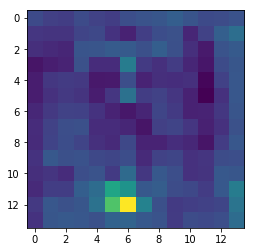

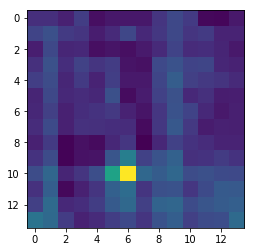

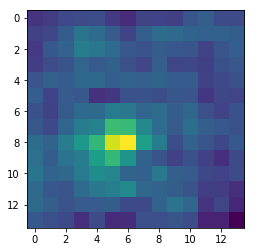

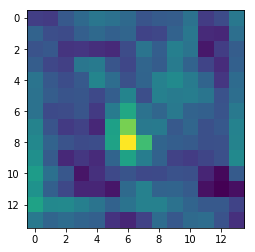

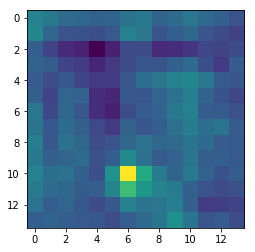

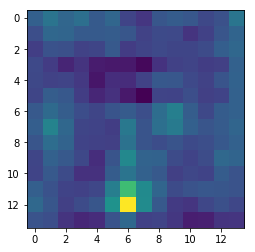

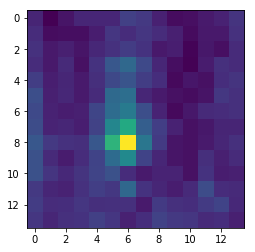

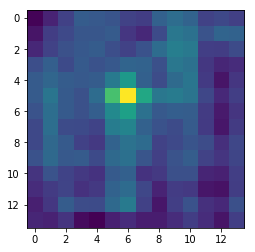

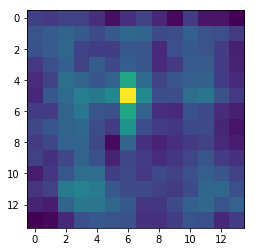

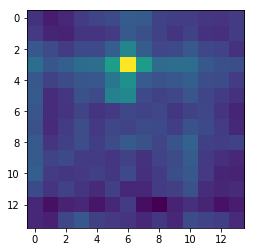

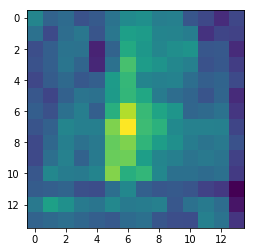

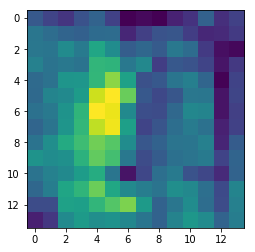

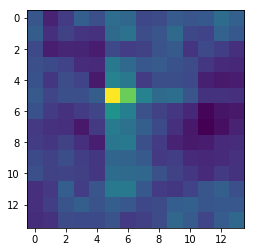

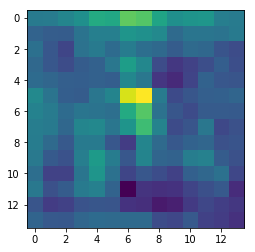

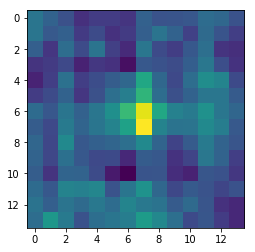

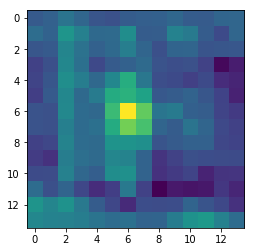

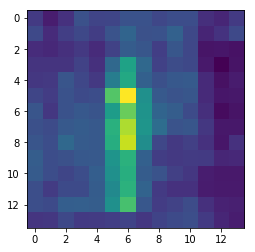

In [7]:
network_output_width = 14
_transpose_heatmap = np.squeeze(heatmap)
_transpose_vectormap = np.squeeze(vectormap)
print("_transpose_heatmap's shape : ", np.shape(_transpose_heatmap))
print("_transpose_vectormap's shape : ", np.shape(_transpose_vectormap))
__transpose_heatmap = np.transpose(_transpose_heatmap, (0, 3, 1, 2))
__transpose_vectormap = np.transpose(_transpose_vectormap, (0, 3, 1, 2))
print("__transpose_heatmap's shape : ", np.shape(__transpose_heatmap))
print("__transpose_vectormap's shape : ", np.shape(__transpose_vectormap))
buffer = np.zeros((network_output_width, network_output_width))
print(np.shape(__transpose_heatmap))#60 17 14 14
for j in range(16):
    buffer = buffer + __transpose_heatmap[0][j]
    plt.imshow(__transpose_heatmap[0][j])
    plt.show()
plt.imshow(buffer)
plt.show()

---------------heatmap------------------------


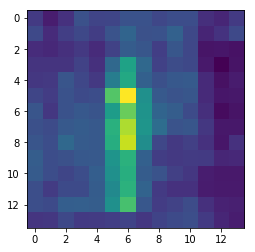

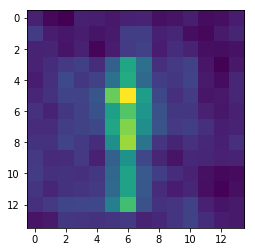

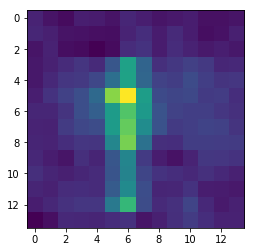

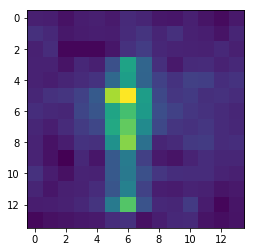

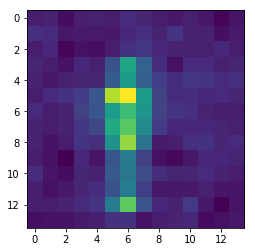

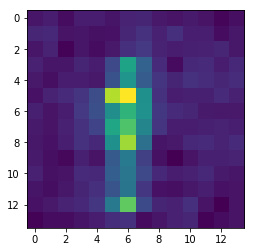

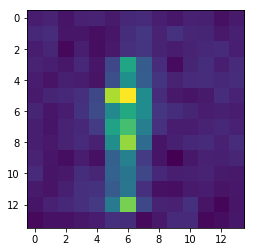

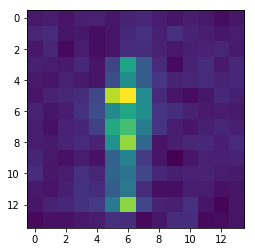

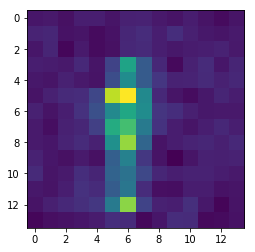

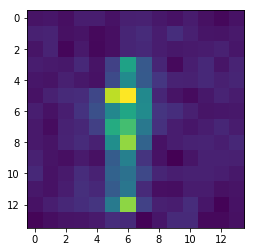

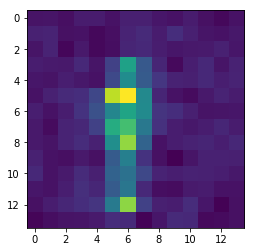

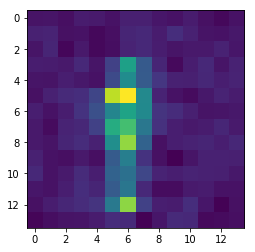

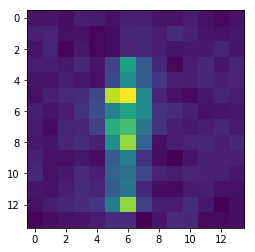

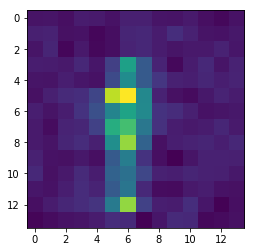

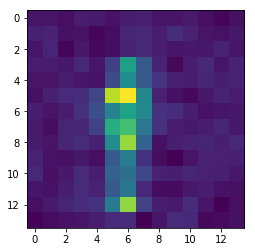

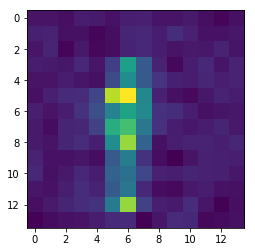

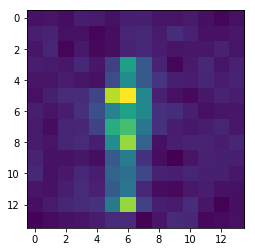

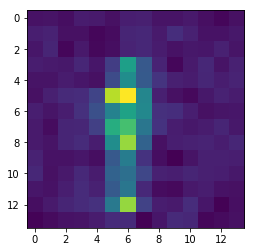

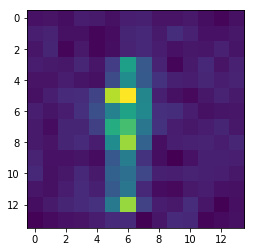

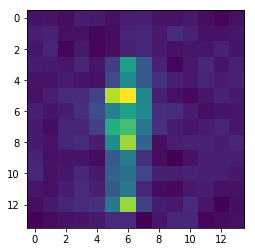

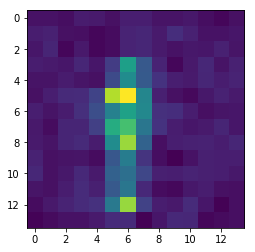

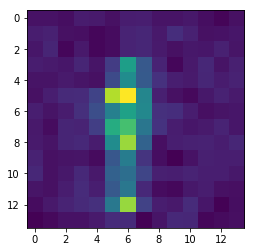

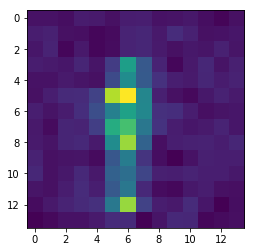

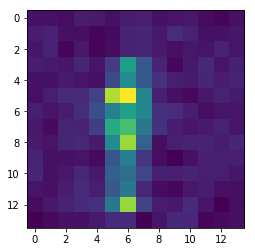

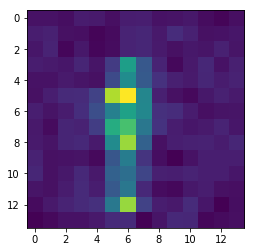

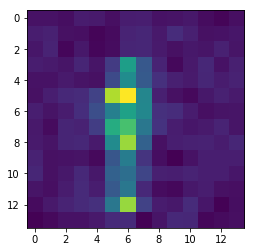

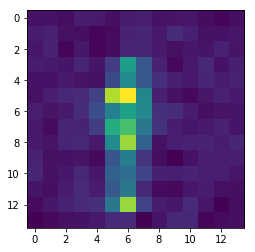

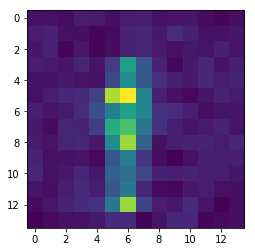

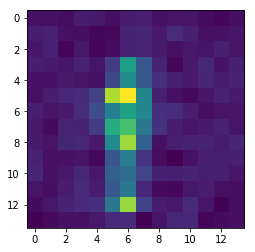

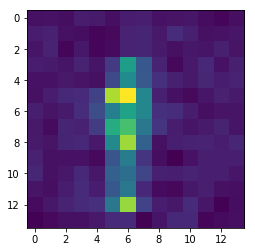

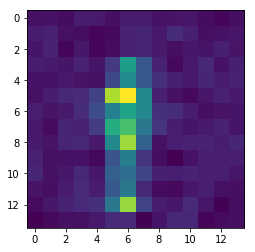

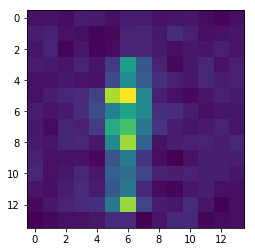

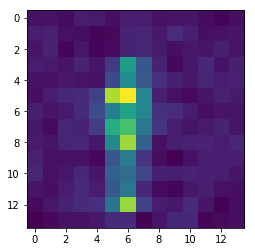

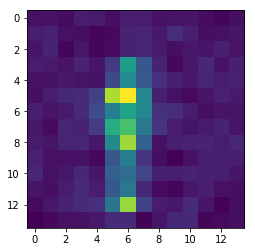

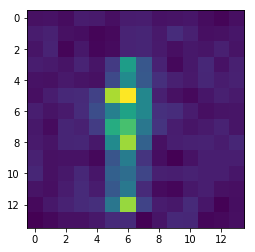

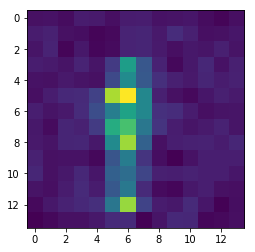

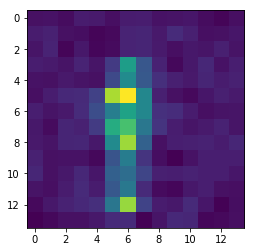

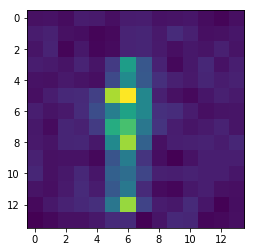

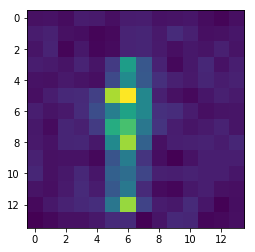

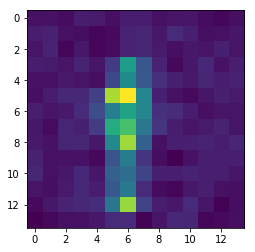

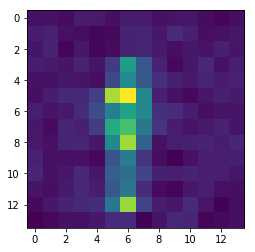

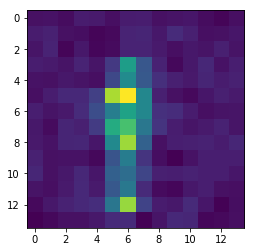

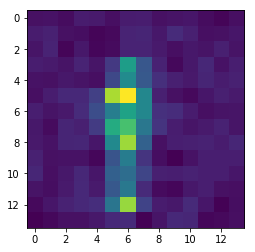

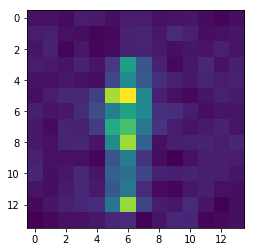

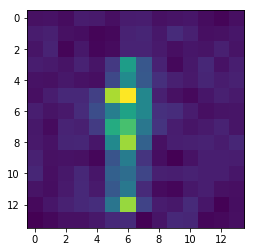

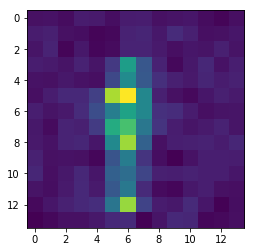

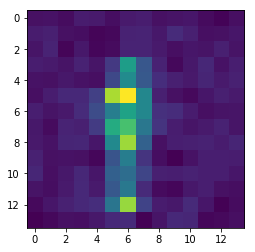

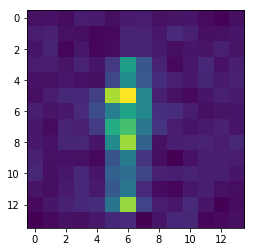

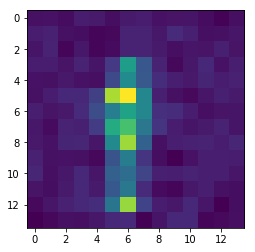

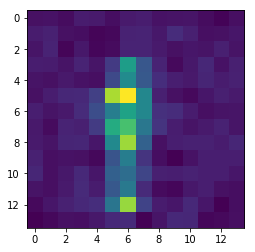

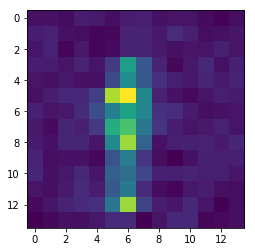

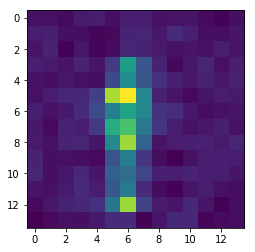

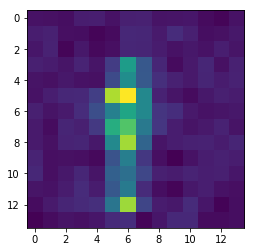

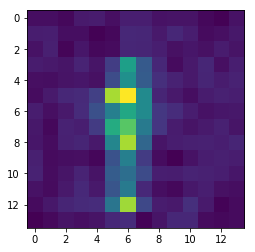

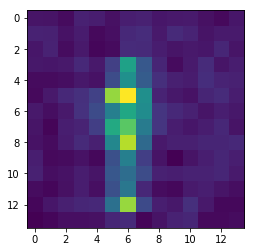

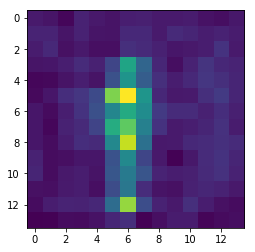

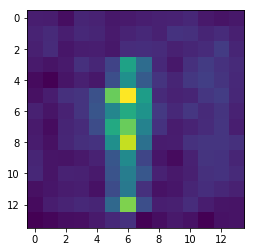

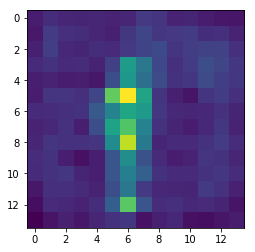

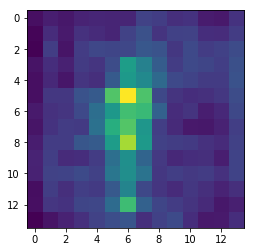

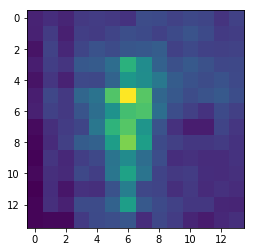

---------------vectormap------------------------


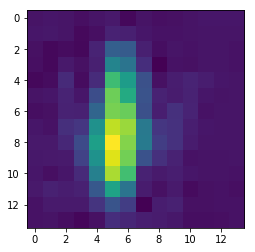

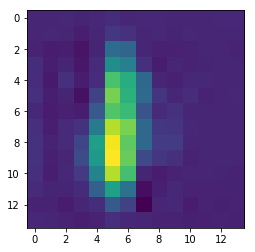

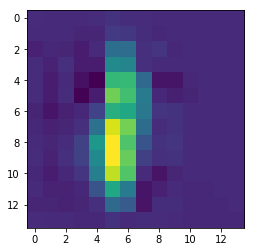

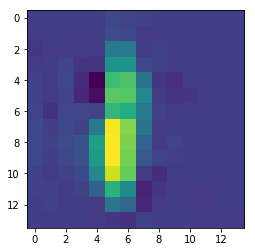

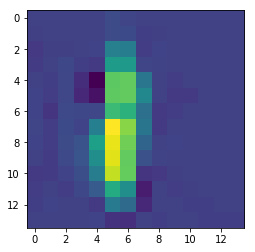

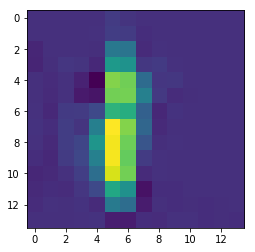

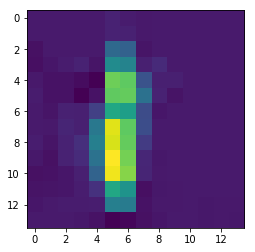

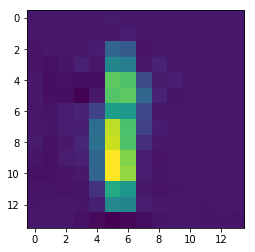

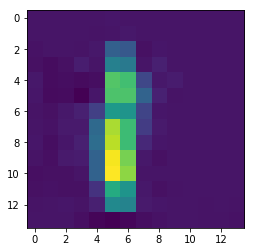

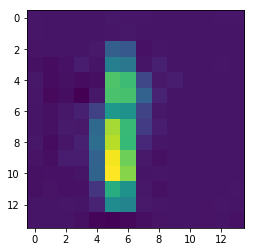

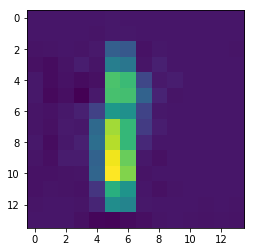

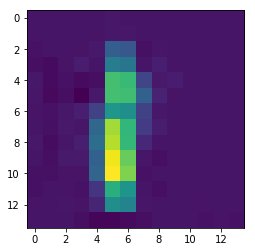

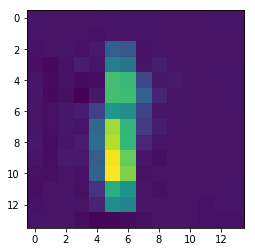

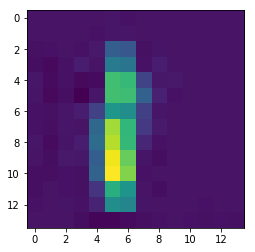

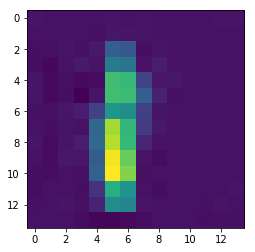

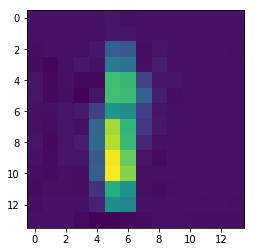

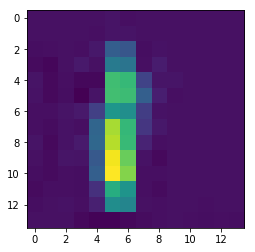

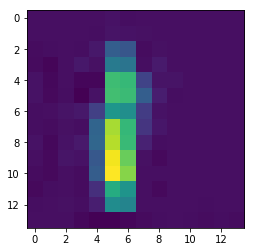

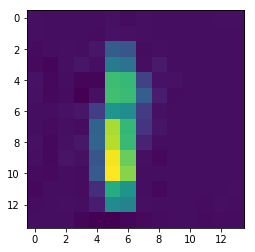

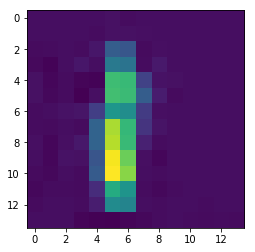

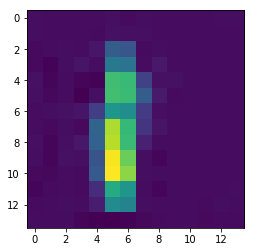

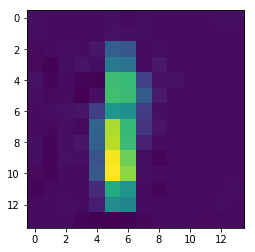

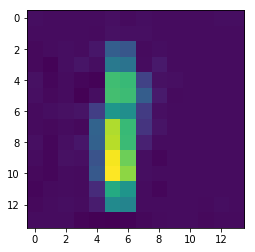

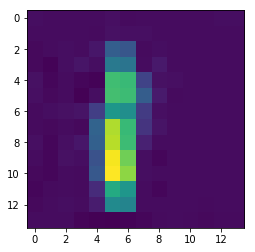

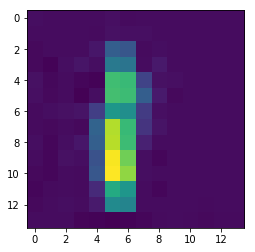

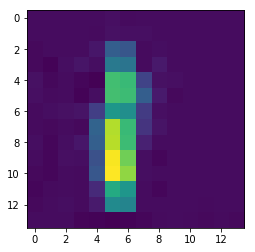

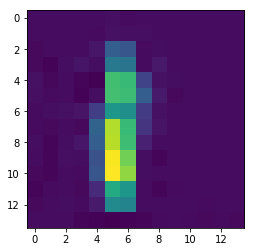

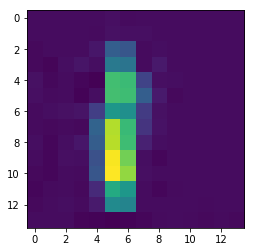

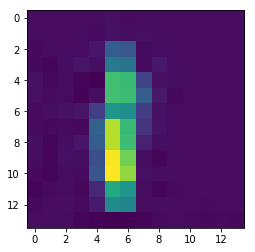

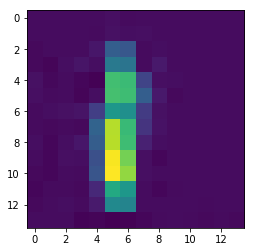

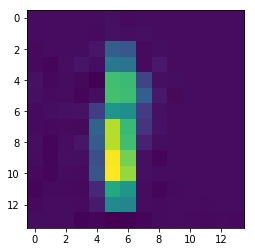

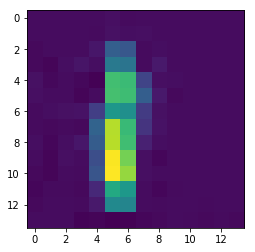

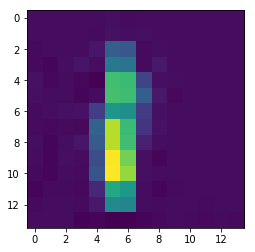

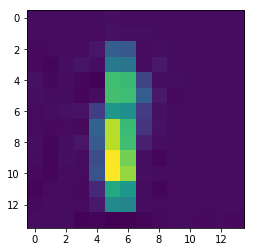

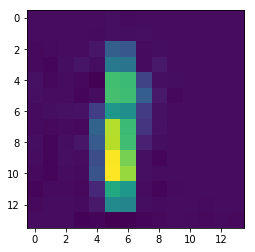

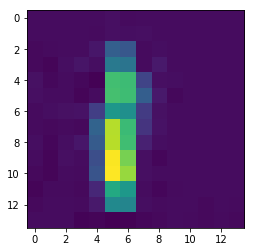

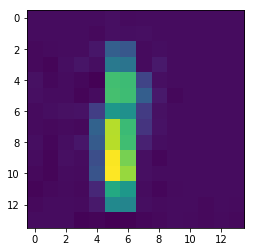

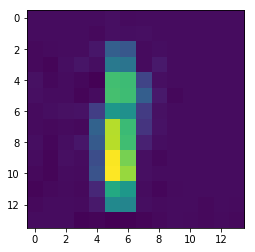

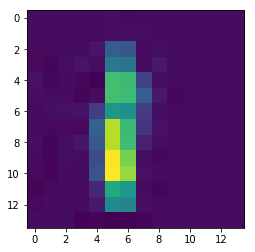

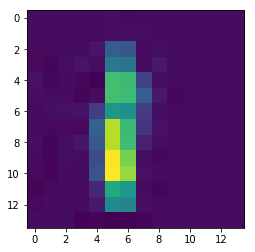

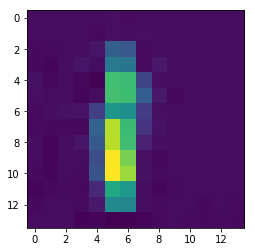

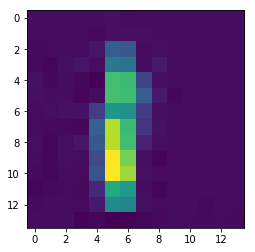

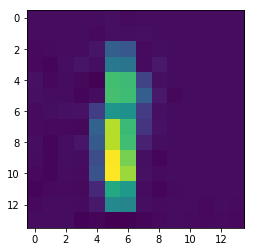

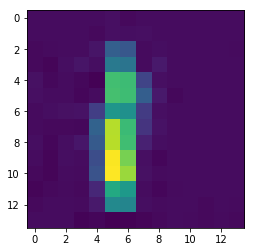

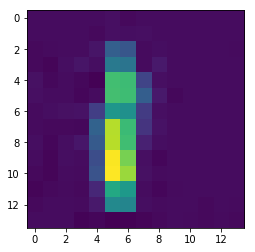

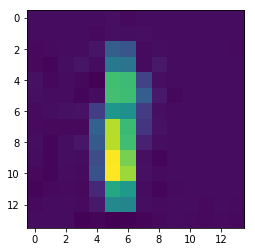

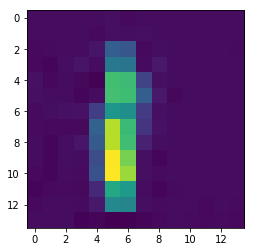

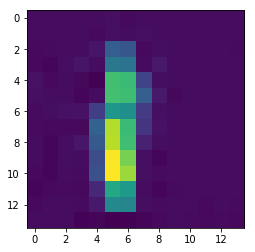

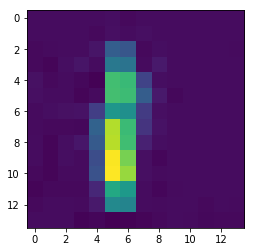

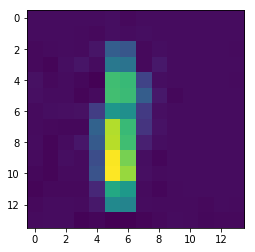

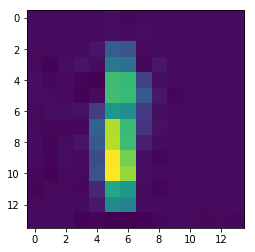

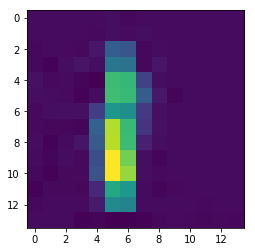

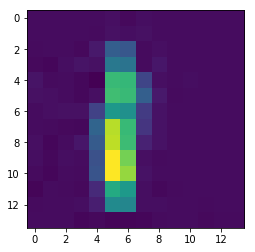

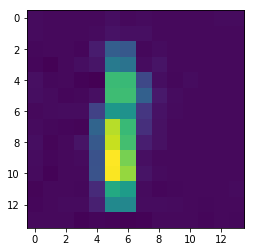

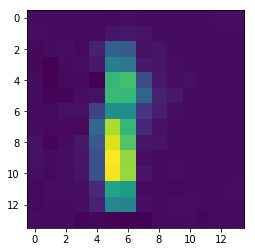

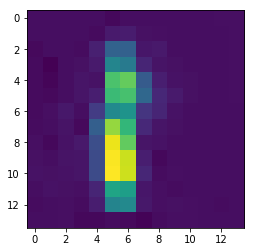

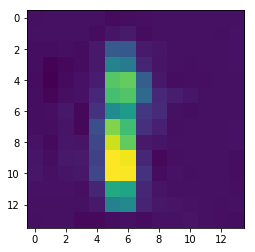

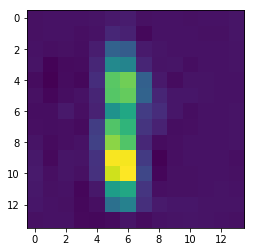

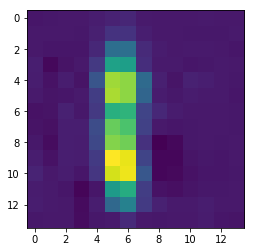

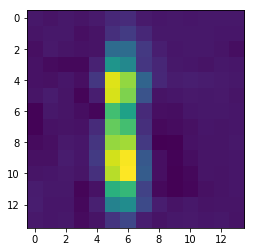

In [8]:
print("---------------heatmap------------------------")
for i in range(60):
    buffer = np.zeros((network_output_width, network_output_width))
    for j in range(16):
        buffer = buffer + __transpose_heatmap[i][j]
    plt.imshow(buffer)
    plt.show()
print("---------------vectormap------------------------")
for i in range(60):
    buffer2 = np.zeros((network_output_width, network_output_width))
    for j in range(32):
        buffer2 = buffer2 + __transpose_vectormap[i][j]
    plt.imshow(buffer2)
    plt.show()

In [9]:
hm = np.zeros((60, 17, 112, 112))
vm = np.zeros((60, 34, 112, 112))
for i in range(60):
    resized_heatmap = np.zeros((17, 112, 112))#112->14
    resized_vectormap = np.zeros((34, 112, 112))
    
    _paf = np.squeeze(vectormap)
    _heatmap = np.squeeze(heatmap)
    #print(np.shape(_heatmap))#60,14,14,17
    #print(np.shape(_paf))#60,14,14,34
    transposed_heatmap = np.transpose(_heatmap[i], (2,0, 1))
    transposed_vectormap = np.transpose(_paf[i], (2,0, 1))##0, 1, 1, 0
    
    for j in range(17):
        resized_heatmap[j] = cv2.resize(transposed_heatmap[j], (112, 112))
    for j in range(34):
        resized_vectormap[j] = cv2.resize(transposed_vectormap[j], (112, 112))
    hm[i] = resized_heatmap
    vm[i] = resized_vectormap
#print(np.shape(hm))

In [10]:
#for i in range(60):
#    for j in range(17):
#        plt.imshow(hm[i][j])
#        plt.show()
np.shape(_60_frame_data)

(1, 60, 112, 112, 3)

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


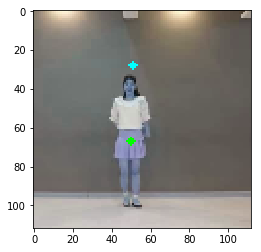

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


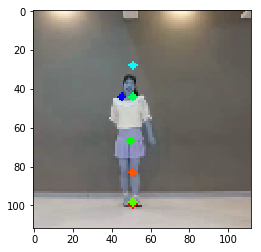

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


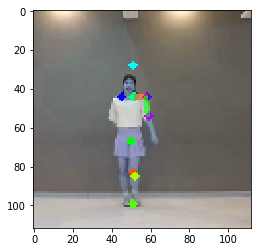

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


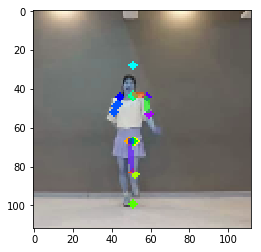

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


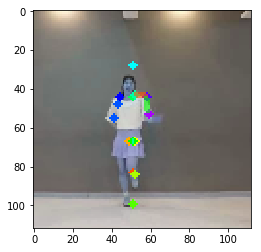

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


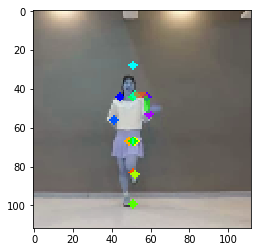

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


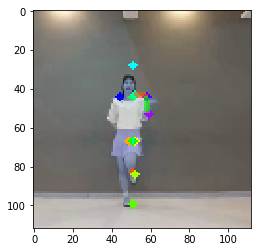

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


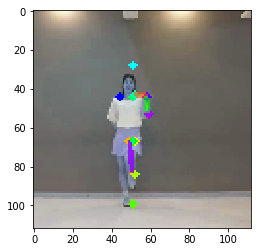

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


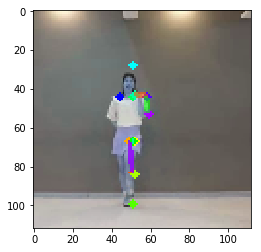

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


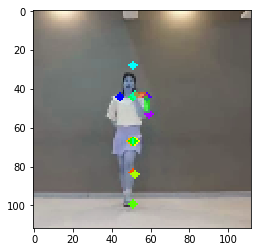

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


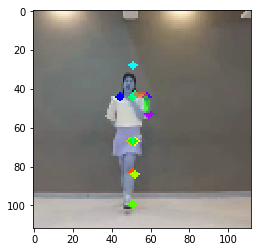

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


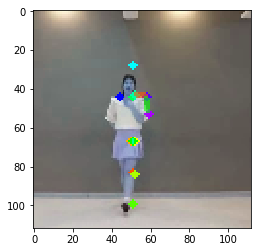

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


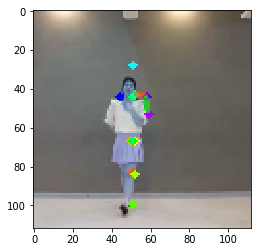

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


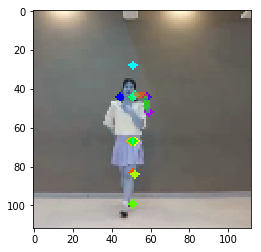

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


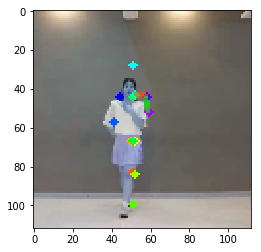

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


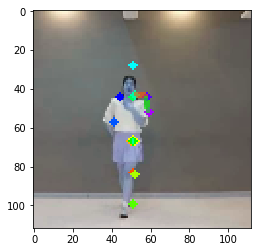

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


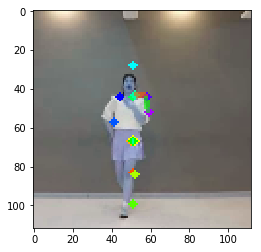

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


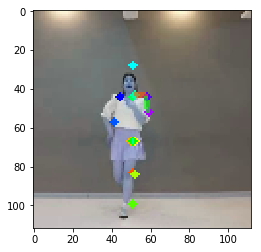

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


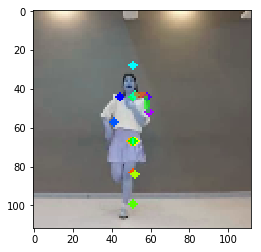

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


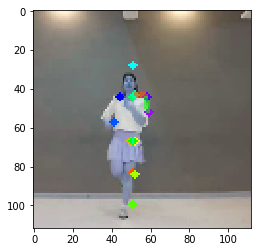

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


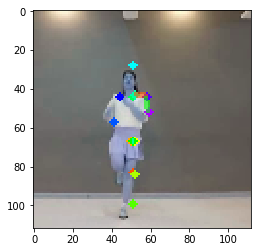

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


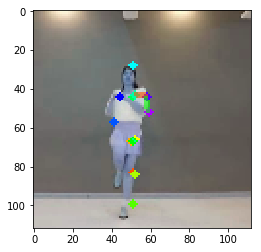

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


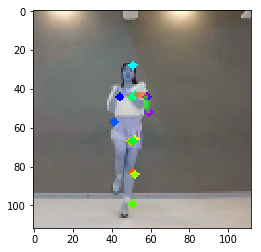

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


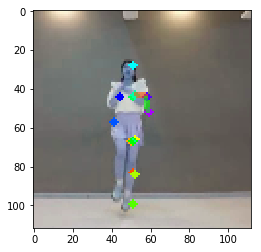

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


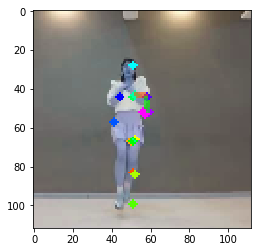

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


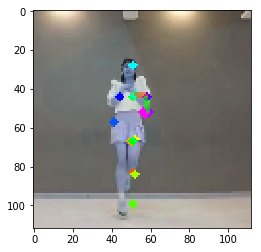

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


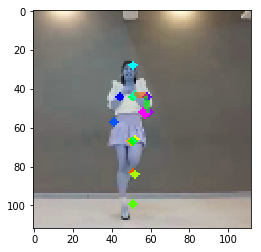

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


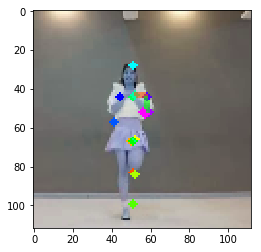

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


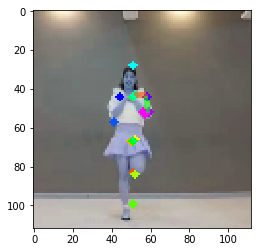

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


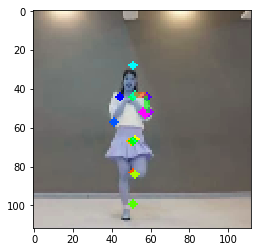

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


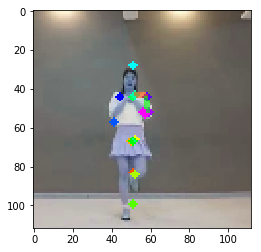

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


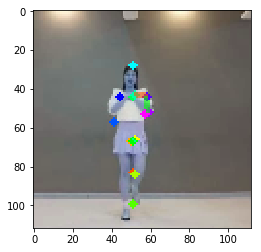

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


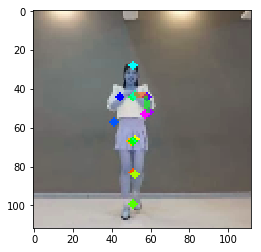

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


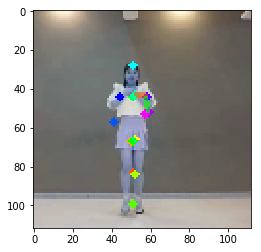

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


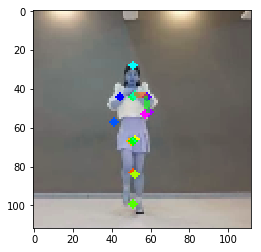

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


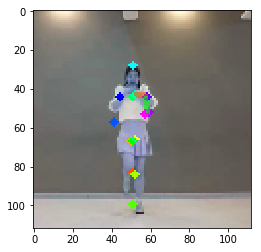

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


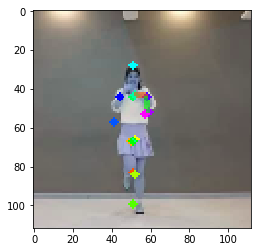

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


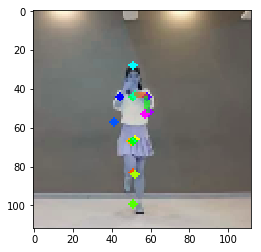

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


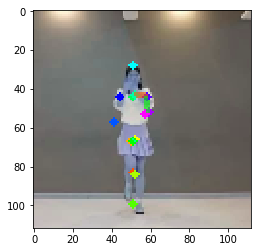

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


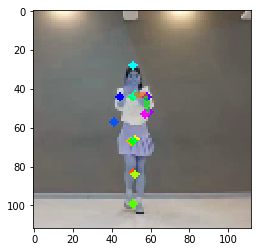

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


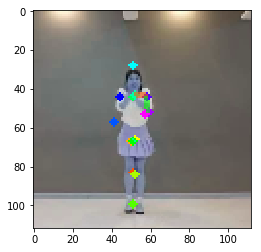

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


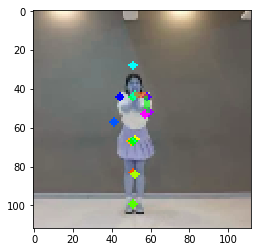

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


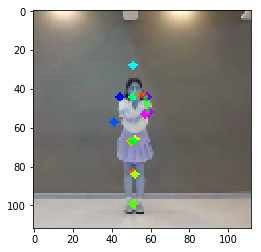

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


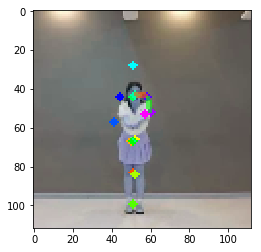

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


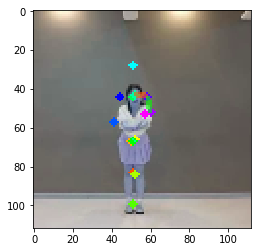

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


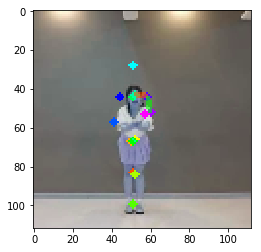

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


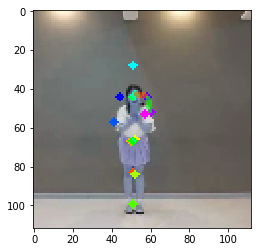

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


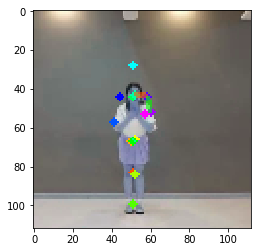

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


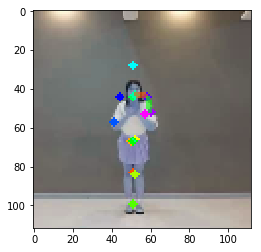

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


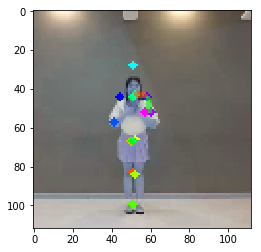

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


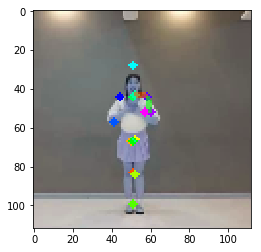

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


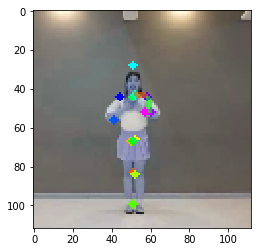

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


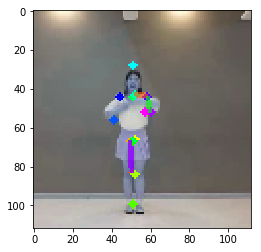

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


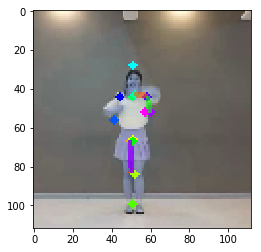

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


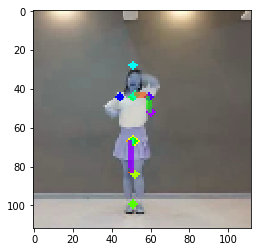

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


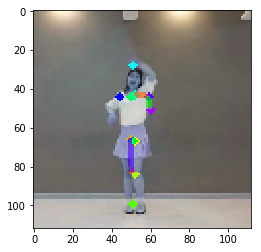

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


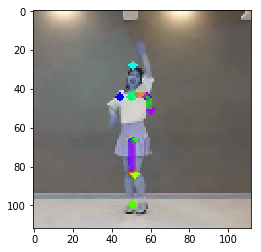

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


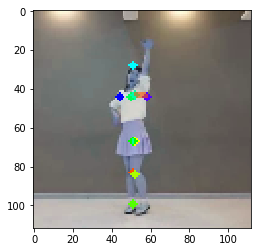

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


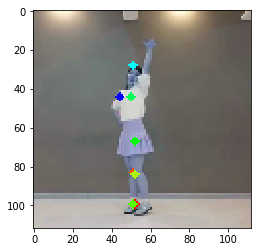

transposed_heatmap :  (60, 17, 112, 112)
(60, 112, 112, 3) (112, 112, 17) (112, 112, 34)


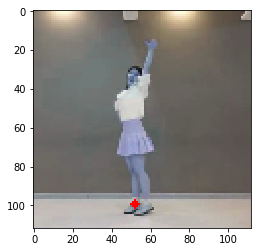

In [11]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path,fourcc, 20.0, (112,112))
#for i in range(len(_60_frame_data)):
#    plt.imshow(_60_frame_data[i])
#    plt.show()
_60_frame_data_squeeze = np.squeeze(_60_frame_data)
for i in range(60):
    print("transposed_heatmap : ", np.shape(hm))
    
    transposed_hm = np.transpose(hm[i], (1,2, 0))
    transposed_vm = np.transpose(vm[i], (1,2, 0))
    print(np.shape(_60_frame_data_squeeze), np.shape(transposed_hm), np.shape(transposed_vm))
    #plt.imshow(_60_frame_data[i])
    #plt.show()
    # 캡쳐되지 않은 경우 처리
    output = demo_view(_60_frame_data_squeeze[i], transposed_hm, transposed_vm)
    
    output = output[...,::-1]
    #plt.imshow(_60_frame_data[i])
    #plt.show()
    plt.imshow(output)
    plt.show()
    out.write(output)
    
    
out.release()

In [ ]:
#_60_frame_data
for i in range(len(_60_frame_data)):
    plt.imshow(_60_frame_data[i])
    plt.show()

In [ ]:
ha = cv2.resize(hmap[0], (112, 112))
cv2.imshow('i',ha)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
np.shape(_heatmap[0])

In [ ]:
hmap = np.transpose(_heatmap[0], [2, 0, 1])

In [ ]:
for i in range(17):
    buffer = cv2.resize(hmap[i], (224, 224))
    plt.imshow(buffer)
    plt.show()

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output2.avi',fourcc, 30.0, (356,356))
#while(True):
video_path = "./video_with_abstacle/test/"
cap = cv2.VideoCapture(video_path)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in range(length):
    ret, img_color = cap.read()
    #print(np.shape(img_color))
    img_color = cv2.resize(img_color, (356, 356))
    heatmap, vectormap = obj.demo_test([img_color])

    heatmap = np.squeeze(heatmap)
    vectormap = np.squeeze(vectormap)
    #print("v : ", np.shape(vectormap))
    resized_heatmap = np.zeros((17, 356, 356))
    resized_vectormap = np.zeros((34, 356, 356))

    heatmap = np.transpose(heatmap, (2,0, 1))
    vectormap = np.transpose(vectormap, (2,0, 1))
    #print("v : ", np.shape(vectormap))
    for i in range(17):
        resized_heatmap[i] = cv2.resize(heatmap[i], (356, 356))
    for i in range(34):
        resized_vectormap[i] = cv2.resize(vectormap[i], (356, 356))

    resized_heatmap = np.transpose(resized_heatmap, (1,2, 0))
    resized_vectormap = np.transpose(resized_vectormap, (1,2, 0))

    # 캡쳐되지 않은 경우 처리
    output = demo_view(img_color, resized_heatmap, resized_vectormap)

    out.write(output)



    if ret == False:
        continue
    output = output[...,::-1]
    cv2.imshow('bgr', output)
    #27 -> esc
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()


In [8]:
np.shape(vgg_output)

(1, 60, 14, 14, 20)

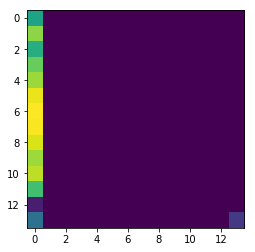

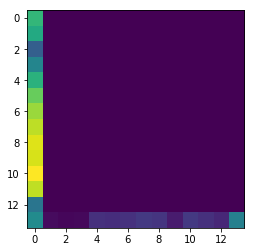

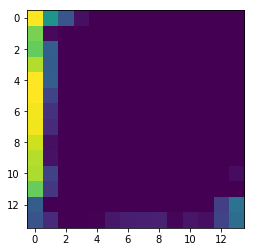

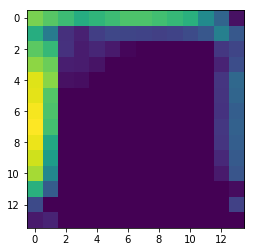

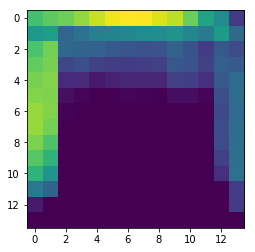

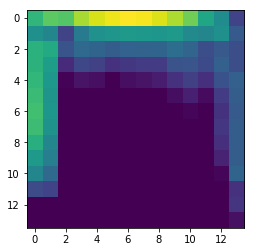

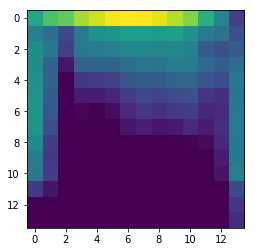

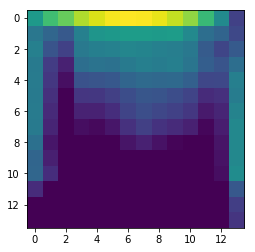

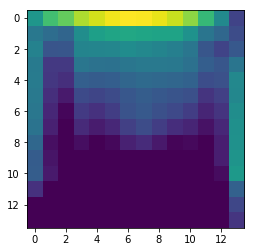

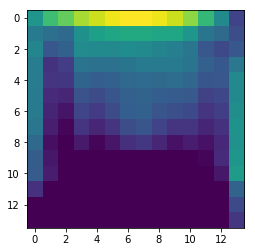

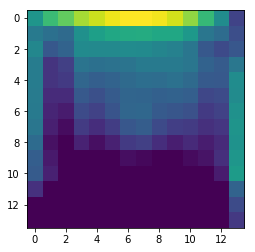

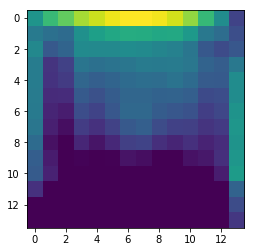

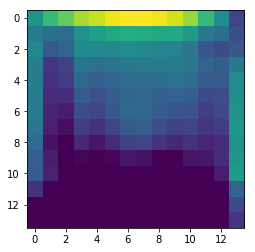

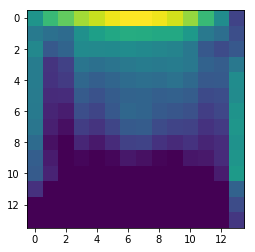

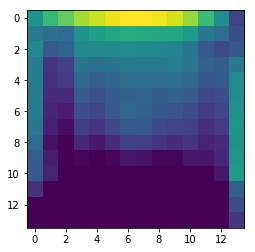

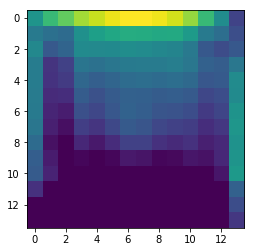

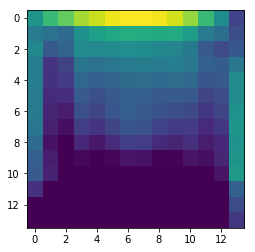

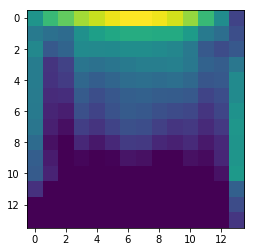

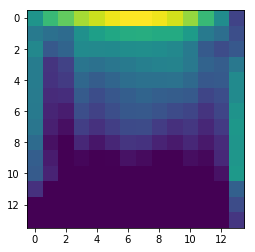

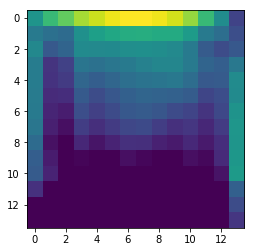

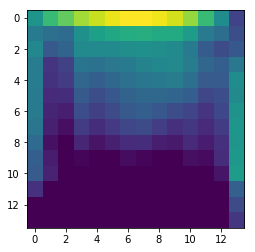

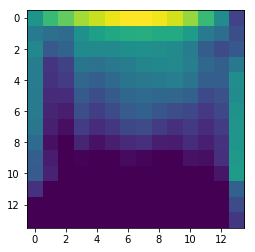

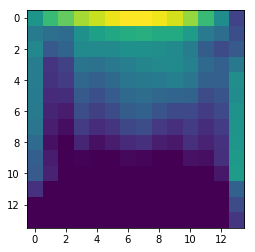

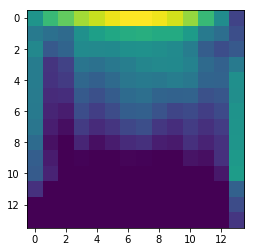

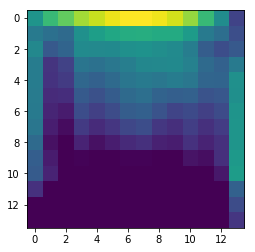

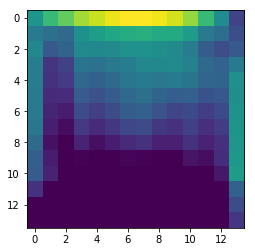

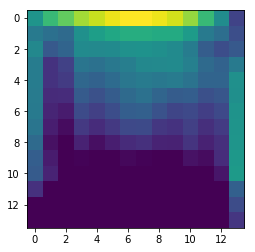

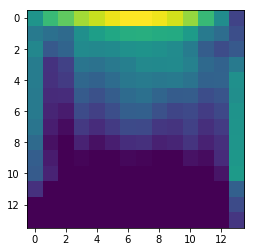

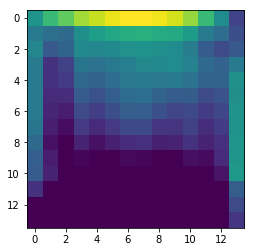

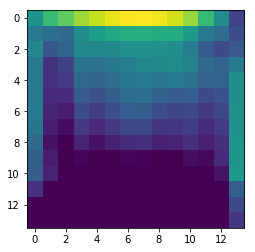

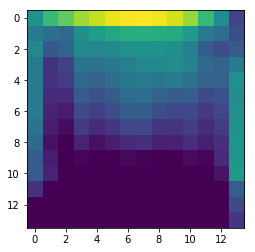

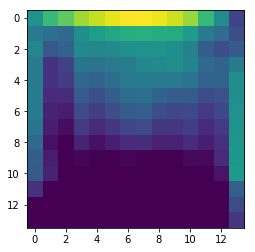

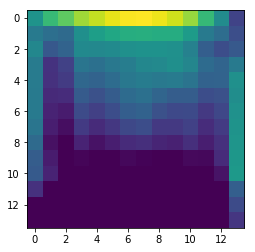

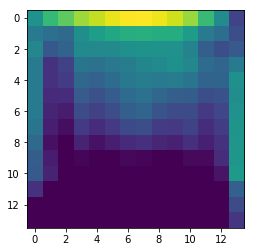

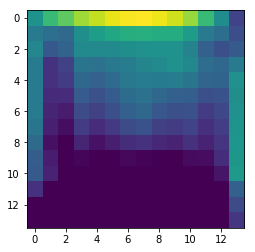

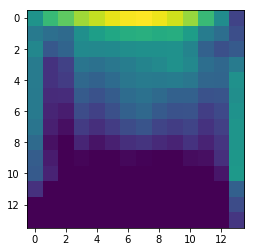

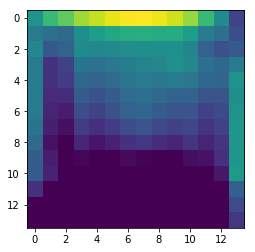

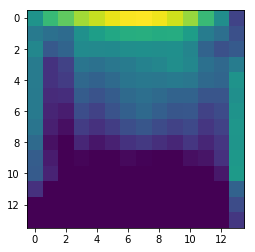

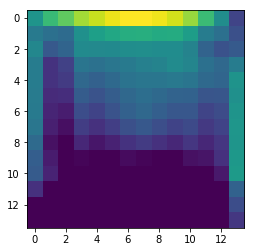

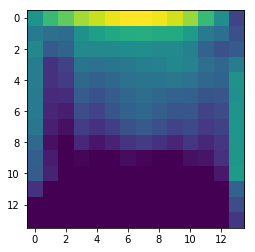

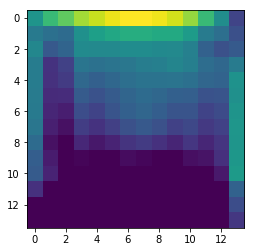

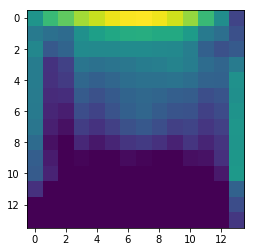

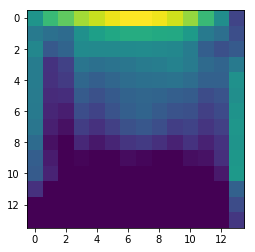

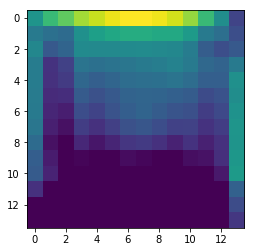

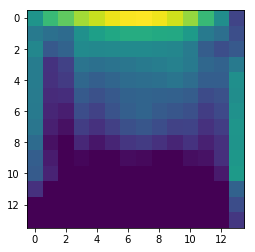

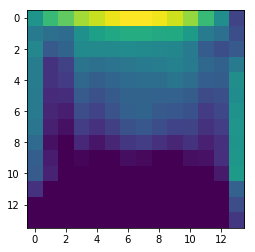

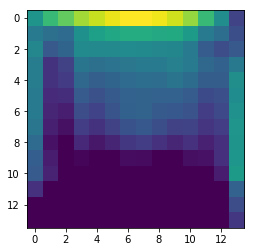

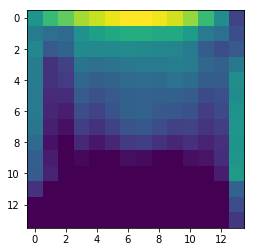

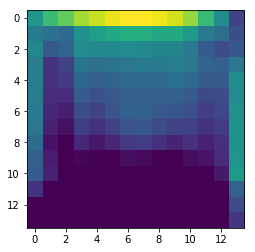

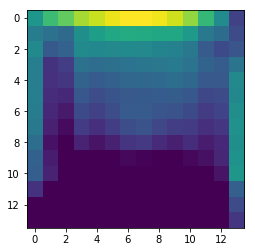

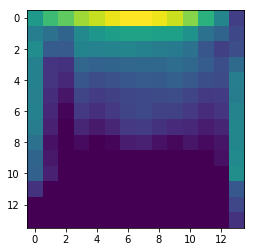

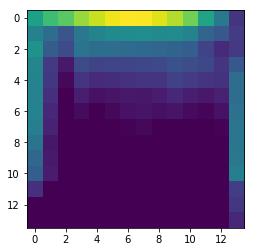

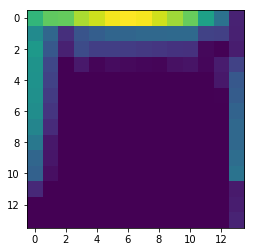

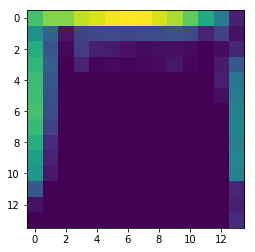

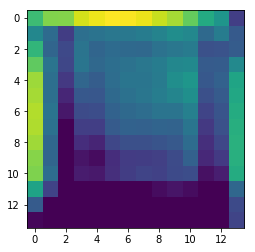

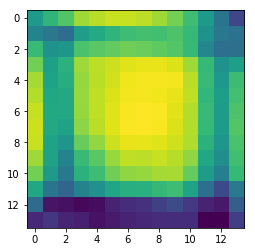

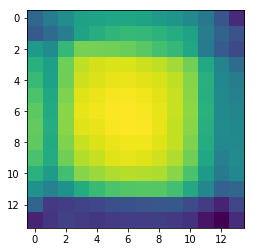

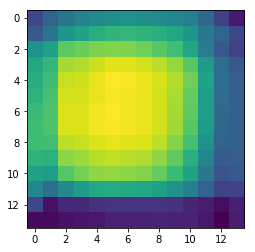

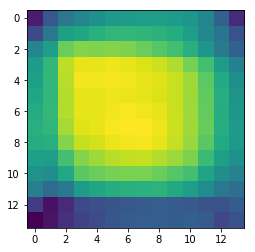

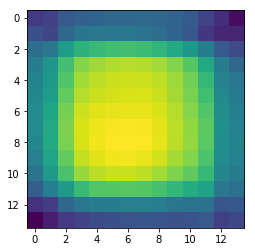

In [12]:
for i in range(60):
    plt.imshow(vgg_output[0][i][:,:,10])
    plt.show()

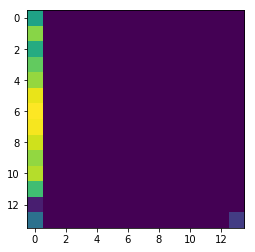

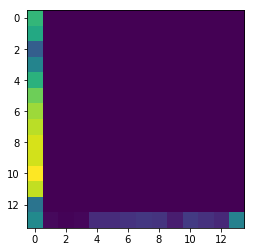

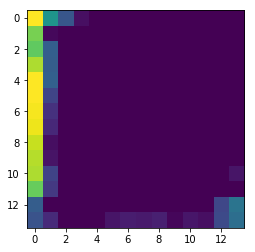

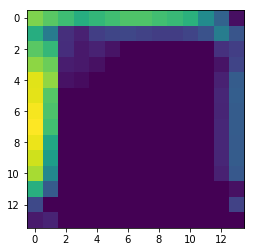

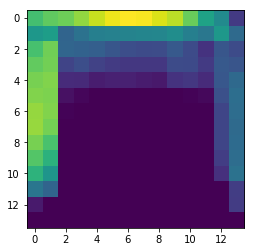

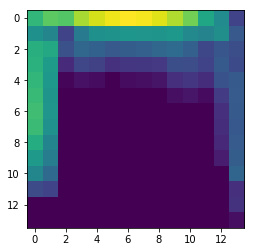

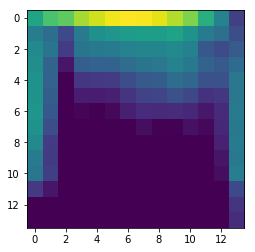

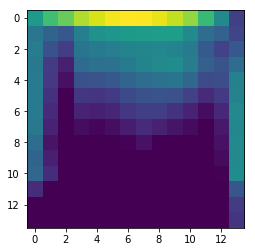

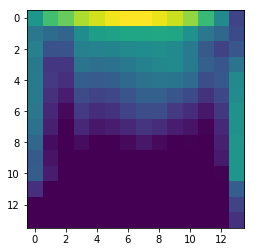

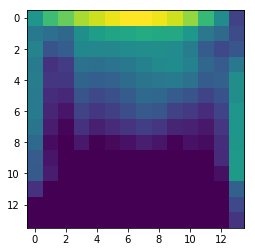

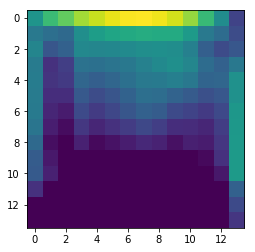

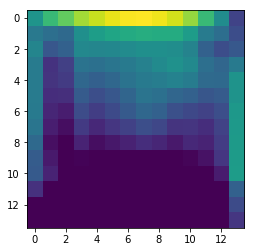

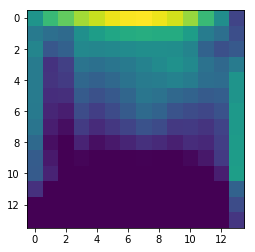

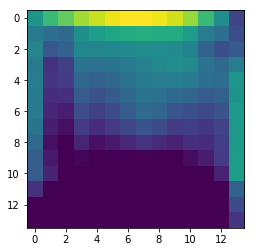

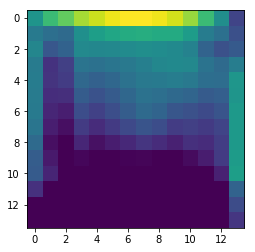

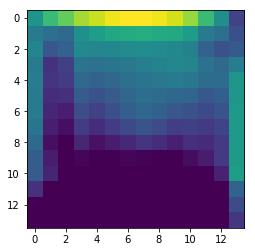

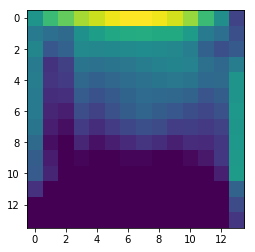

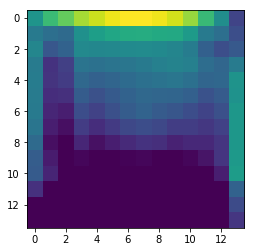

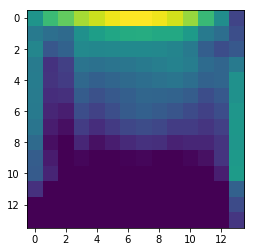

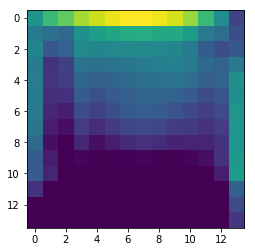

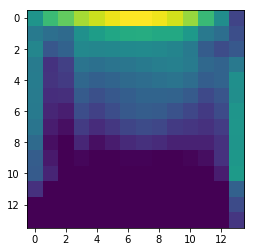

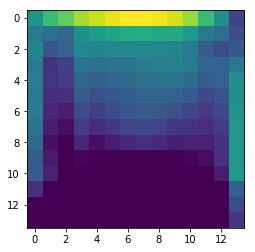

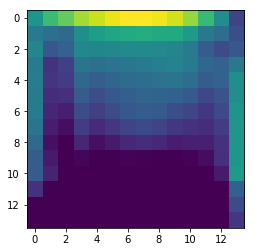

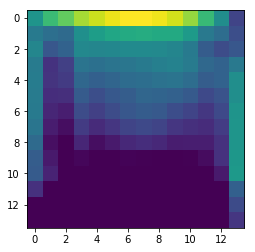

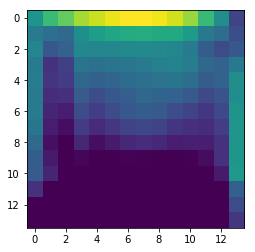

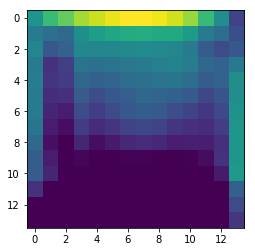

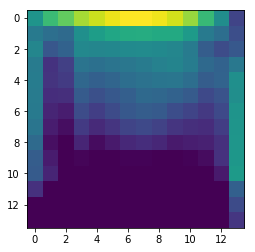

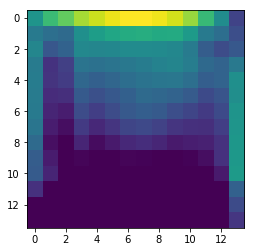

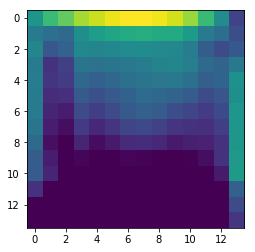

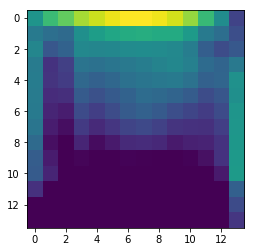

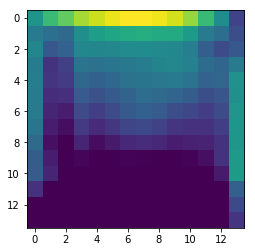

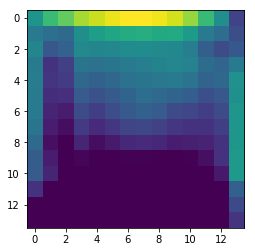

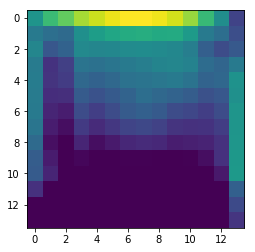

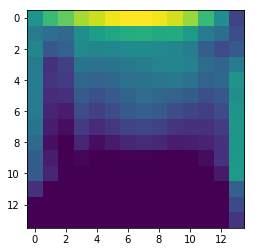

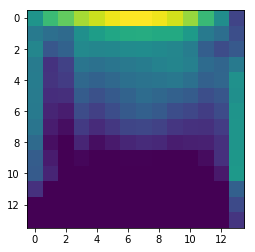

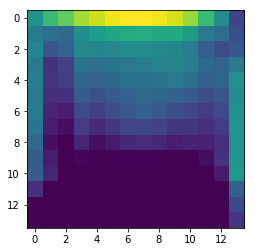

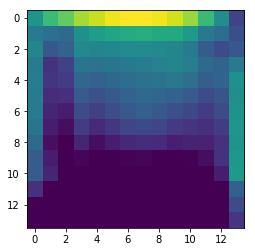

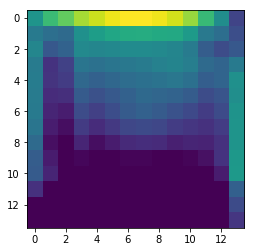

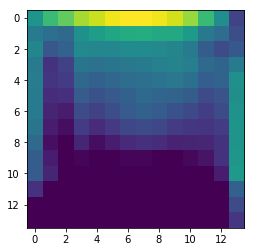

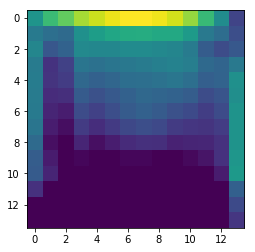

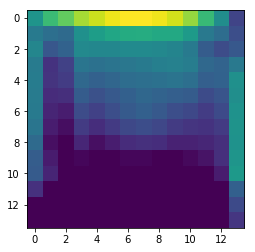

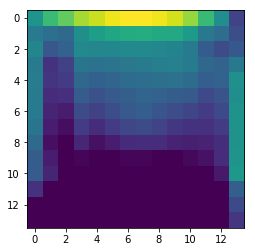

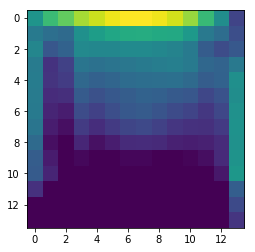

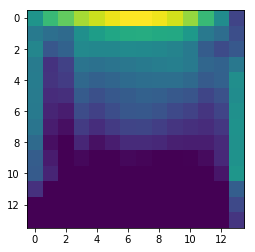

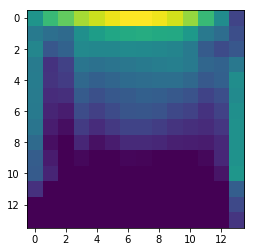

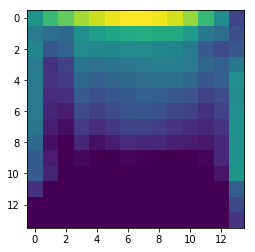

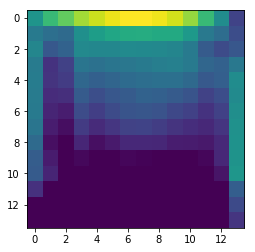

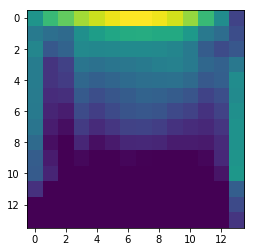

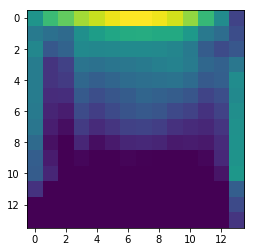

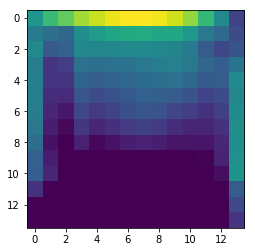

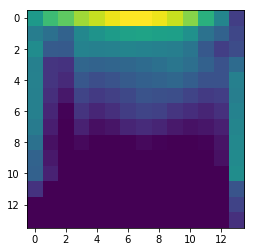

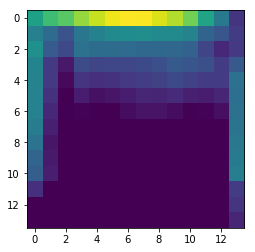

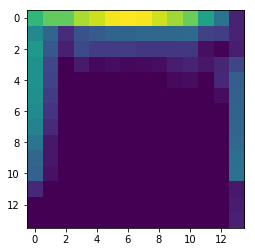

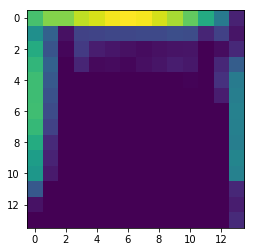

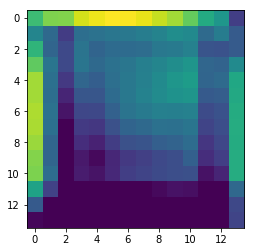

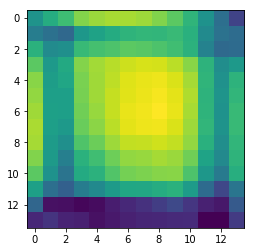

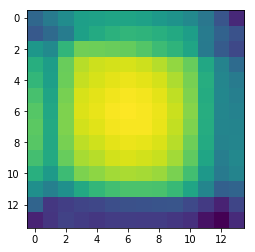

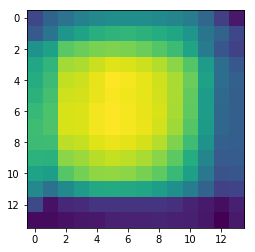

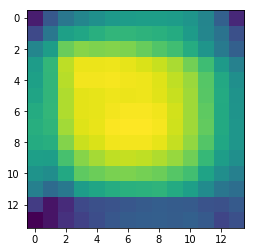

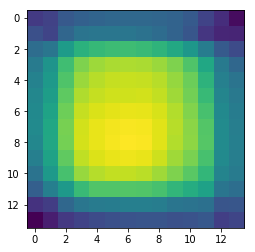

In [7]:
for i in range(60):
    plt.imshow(vgg_output[0][i][:,:,10])
    plt.show()